In [2]:
import sys
import os
import importlib
import random

import numpy as np
import scipy
import sklearn

import torch
import torch.nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

In [3]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [4]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

# Load Data

In [5]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load("../../data/raw_feat/cv_dist_spin_anton2.npy"))

In [6]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [7]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy"))

In [8]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(4150115, 2) (4150115, 60)


In [84]:
# load committors
qp_du = np.load("../../data/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns
w = np.load(
    "../../data/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[0]

In [10]:
rf161 = list(np.load("../../data/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load("../../data/raw_feat/rf161_anton2.npy"))
rf161_arr = np.concatenate(rf161)

# Constrained Optimization

We use the following ansatz for the committor:

$\renewcommand{\v}[1]{\textbf{#1}}$
\begin{equation}
q_+(t; \v e) = \frac 1 2\left[ 1 + \mathrm{erf} \left(\frac{\v e \cdot (\v z(t) - \v z_0)}{\sigma}\right)\right]
\end{equation}
where $\v e$ is the normal vector (normalized to unity) at the isocommittor-0.5 surface and $\sigma$ is the bandwidth of the underlying Gaussian.
Also, $\v z$ is the vector of collective variables and $\v z_0$ is some reference (we take it to be the weighted average of $\v z$ at $q_+\approx 0.5$).

We want to variationally minimize the following correlation function:
\begin{equation}
C(\tau) = \langle q(0) q(\tau)\rangle - \langle q(0)^2\rangle
\end{equation}
where the dependence on $\v e$ is implicit, i.e.
\begin{align}
\hat{\v e}  = &\min_{\v e} C(\tau; \v e) \\
    &\text{ s.t. } \sum_i e_i^2 = 1.
\end{align}

This can be done using Lagrange multipliers, the Lagrangian is
\begin{equation}
\mathcal{L}(\v e, \lambda) = C(\tau) - \lambda\left(\sum_i e_i^2 - 1\right)
\end{equation}
which we differentiate to yield the system of equations
$\newcommand{\pdvei}{\frac{\partial}{\partial e_i}}$
\begin{equation}
    \begin{cases}
    \pdvei \mathcal L(\v e, \lambda) = \left\langle q(\tau) \pdvei q(0) + q(0) \pdvei q(\tau) - 2q(0) \pdvei q(0)\right\rangle - 2\lambda e_i = 0\\
    \frac{\partial}{\partial \lambda} \mathcal L(\v e, \lambda) = 1 - \sum_i e_i^2 = 0
    \end{cases}
\end{equation}
where we have
\begin{equation}
\pdvei q(t) = \frac{z_i}{\sigma \sqrt{\pi}} \exp \left[ - \left( \frac{\v e \cdot (\v z(t) - \v z_0)}{\sigma} \right)^2\right ].
\end{equation}

In [101]:
from numba import jit

In [132]:
# @jit
def q(e, z, z0, sigma=1):
    """Compute the value of the committor for a trajectory z given
    a unit vector e
    
    z : ndarray of shape (n_frames, n_features)
    z0 : ndarray of shape (n_features,)
    """
    arg = np.dot((z - z0), e) / sigma
    return 0.5 * (1 + scipy.special.erf(arg))

@jit
def q_pdiff_i(i, e, z, z0, sigma=1):
    """Compute the partial derivative of the committor for a trajectory
    z given a unit vector e with respect to the i'th entry.
    """
    arg = np.dot((z - z0), e) / sigma
    return z[:, i] * np.exp(-arg * arg) / (sigma * np.sqrt(np.pi))

def lagrange_diff_i(i, e, lmbda, z_traj, z0, lag, sigma=1):
    ans = 0
    for z in z_traj:
        n = len(z) - lag
        # first term, q(tau) * d/d e_i (q(0))
        ans += np.dot(q(e, z[lag:], z0, sigma=sigma), q_pdiff_i(i, e, z[:-lag], z0, sigma=sigma)) / n
        # second term
        ans += np.dot(q(e, z[:-lag], z0, sigma=sigma), q_pdiff_i(i, e, z[lag:], z0, sigma=sigma)) / n
        # third term
        ans -= 2 * np.dot(q(e, z[:-lag], z0, sigma=sigma), q_pdiff_i(i, e, z[:-lag], z0, sigma=sigma)) / n
    # lambda term
    ans -= 2 * lmbda * e[i]
    return ans

@jit
def q_pdiff(e, z, z0, sigma=1):
    """Compute the gradient of the committor for a trajectory
    z given a unit vector e with respect to e.
    
    Parameters
    ----------
    e : ndarray of shape (n_features,)
        Unit vector controlling direction of committor erf function
    z : ndarray of shape (n_frames, n_features)
        Array of collective variables
    z0 : float
    
    Returns
    -------
    ans : ndarray of shape (n_features,)
        Gradient of erf committor with respect to the input vector e
    """
    arg = np.dot((z - z0), e) / sigma
    ans = z.T * np.exp(-arg * arg) / (sigma * np.sqrt(np.pi))
    return ans

def dL_e(e, lmbda, z_traj, z0, lag, sigma=1):
    """Compute the derivatives of the committor correlation function Lagrangian
    with respect to the unit vector e.
    
    Parameters
    ---------- 
    e : ndarray of shape (n_features,)
        Unit vector controlling direction of committor erf function
    lmbda : float
        Lagrange multiplier
    z_traj : array-like of ndarray of shape (n_frames, n_features)
        List of trajectories of collective variables
    z0 : float
    lag : int
    
    Returns
    -------
    ans : ndarray of shape (n_features + 1,)
    """
    ans = 0
    for z in z_traj:
        n = len(z) - lag
        # first term, q(tau) * d/d e_i (q(0))
        ans += np.dot(q_pdiff(e, z[:-lag], z0, sigma=sigma), q(e, z[lag:], z0, sigma=sigma)) / n
        # second term
        ans += np.dot(q_pdiff(e, z[lag:], z0, sigma=sigma), q(e, z[:-lag], z0, sigma=sigma)) / n
        # third term
        ans -= 2 * np.dot(q_pdiff(e, z[:-lag], z0, sigma=sigma), q(e, z[:-lag], z0, sigma=sigma)) / n
    # lambda term
    ans -= 2 * lmbda * e
    return ans


def dL(x, z_traj, z0, lag, sigma):
    """
    Parameters
    ----------
    x : ndarray of shape (n_features + 1,)
        Contains the elements of e (unit vector) and lambda
        
    Returns
    -------
    Gradient of Lagrangian with respect to the unit vector e
    and the Lagrange multiplier lambda
    """
    ans = np.zeros_like(x)
    e = x[:-1]
    lmbda = x[-1]
    # for i in range(e):
    #     ans[i] = lagrange_diff_i(i, e, lmbda, z_traj, z0, lag, sigma=sigma)
    ans[:-1] = dL_e(e, lmbda, z_traj, z0, lag, sigma=sigma)
    # derivative of Lagrangian with respect to lambda
    ans[-1] = 1 - np.linalg.norm(e)
    return ans

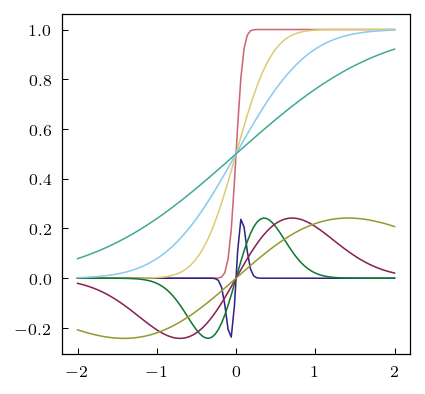

In [83]:
# e = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
e = 1
z = np.linspace(-2, 2, 100)
z0 = 0
for s in (0.1, 0.5, 1.0, 2.0):
    plt.plot(z, q(e, z, z0, sigma=s))
    arg = e * (z - z0) / s
    plt.plot(z, z * np.exp(-arg**2) / (s * np.sqrt(np.pi)))

(100, 100)

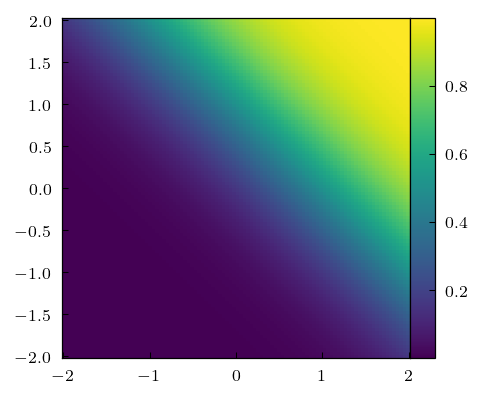

In [70]:
e = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
z1 = np.linspace(-2, 2, 100)
z2 = np.linspace(-2, 2, 100)
z0 = np.ones((2, 1)) * 0.5
X, Y = np.meshgrid(z1, z2)
qp = q(e, np.stack((X, Y), axis=1), z0)
im = plt.pcolor(X, Y, qp.T)
pplt.colorbar(im)

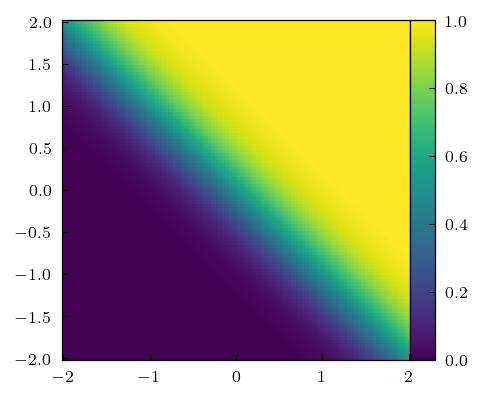

In [69]:
e = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
z1 = np.linspace(-2, 2, 100)
z2 = np.linspace(-2, 2, 100)
z0 = np.zeros((2, 1))
X, Y = np.meshgrid(z1, z2)
qp = q(e, np.stack((X, Y), axis=1), z0, sigma=0.5)
im = plt.pcolor(X, Y, qp.T)
pplt.colorbar(im)

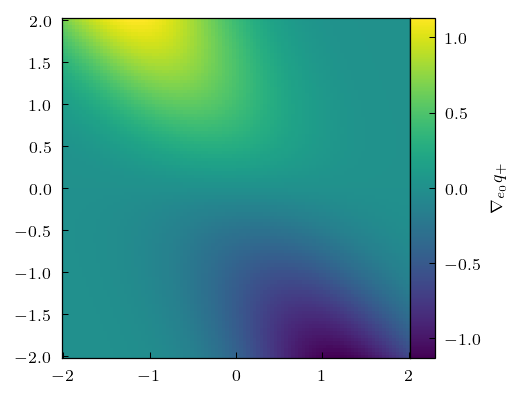

In [78]:
e = np.array([1 / 2, np.sqrt(3 / 4)])
z1 = np.linspace(-2, 2, 100)
z2 = np.linspace(-2, 2, 100)
z0 = np.zeros(2)
X, Y = np.meshgrid(z1, z2)
qp_diff = np.zeros((100, 100, 2))
for i in range(100):
    for j in range(100):
        x = X[i, j]
        y = Y[i, j]
        qp_diff[i, j, 0] = q_pdiff_i(0, e, [x, y], z0)
        qp_diff[i, j, 1] = q_pdiff_i(1, e, [x, y], z0)
im = plt.pcolor(X, Y, qp_diff[:, :, 0].T)
pplt.colorbar(im, label=r"$\nabla_{e_0} q_+$")

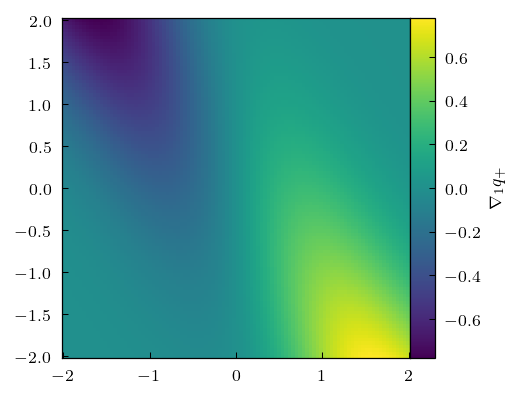

In [77]:
im = plt.pcolor(X, Y, qp_diff[:, :, 1].T)
pplt.colorbar(im, label=r"$\nabla_1 q_+$")

## Real data

In [109]:
offset = 0.05
q_arr = np.concatenate(qp_du)
ts_ids = ((q_arr > (0.5 - offset)) & (q_arr < (0.5 + offset)))
traj_inds = util.split_indices(cv_trajs)
z_arr = np.hstack((cv_arr, sb_arr, rf161_arr))
z_trajs = np.split(z_arr, traj_inds, axis=0)
z0 = np.mean(z_arr[ts_ids], axis=0)

In [110]:
z0.shape

(65,)

In [127]:
dL_e(e, 1, z_trajs, z0, 10)

array([ -0.49563825, -13.49268167,  -0.22860881,  -0.28547939,
        -0.30255221,  -0.16967094,  -0.16754605,  -0.1910226 ,
        -0.27701697,  -0.24789379,  -0.31397284,  -0.27206306,
        -0.25432185,  -0.25355375,  -0.30253196,  -0.24361006,
        -0.30648685,  -0.323049  ,  -0.27344259,  -0.25410973,
        -0.29495121,  -0.23109826,  -0.28684545,  -0.3644264 ,
        -0.31299455,  -0.26559009,  -0.25805204,  -0.21319759,
        -0.25386088,  -0.34083761,  -0.34457897,  -0.27759817,
        -0.20557834,  -0.29574424,  -0.32278939,  -0.18635644,
        -0.1731622 ,  -0.19664816,  -0.21123203,  -0.28766376,
        -0.35704312,  -0.1973946 ,  -0.18843515,  -0.18967942,
        -0.31273169,  -0.3275614 ,  -0.42561367,  -0.20251328,
        -0.15119329,  -0.16174353,  -0.30978804,  -0.23605858,
        -0.31217823,  -0.48150238,  -0.33113695,  -0.22186034,
        -0.31479243,  -0.25866376,  -0.33837027,  -0.46225498,
        -0.5274924 ,  -0.41183558,  -0.21075451,  -0.26

In [125]:
lagrange_diff_i(0, e, 1, z_trajs, z0, 10)

-4.9563824814759505e-01

In [114]:
e = np.ones(65) * np.sqrt(1 / 65)
test_diff = np.zeros(65)
for i in range(65):
    test_diff[i] = lagrange_diff_i(i, e, 1, z_trajs, z0, 10)

KeyboardInterrupt: 

In [ ]:
dl = dL_e(e, , z_trajs, z0, 10)

In [ ]:
lag = 500
sigma = 1
x0 = np.ones(66)
x0[:65] *= np.sqrt(1 / 65)
roots = scipy.optimize.fsolve(dL, x0, args=(z_trajs, z0, lag, sigma), full_output=True)